# This script processes SYCL and CUDA results 

1. Go to SYCL-CUDA directory and compile all versions with:
```
make
```
2. Run the benchmarking script
```
cd scripts
python3 run_sycl_cuda.py
```
3. The output that we will process is sycl_cuda_coffee.txt (renamed from sycl_cuda_output.out)



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize(filename):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                version=tokens[1].split("/")[2]
                input=tokens[2].split("/")[3][:-4]
                match input:
                    case "INAER_2011_Alcoy_Core":
                       cloud="Alcoy"
                    case "BABCOCK_2017_Arzua_3B":
                        cloud="Arzua"
                    case "V21_group1_densified_point_cloud":
                        cloud="BrionF"
                    case "V19_group1_densified_point_cloud":
                        cloud="BrionU"
                maxNum=int(tokens[3])
                if version not in experiment:
                    
                    experiment[version]={}
                if cloud not in experiment[version]:
                    experiment[version][cloud]={}
                experiment[version][cloud][maxNum]=[]
            if 'Construction' in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Stage1" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Stage2" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if "Total" in tokens and "KERNEL" in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[5]))
            if 'TIME' in tokens:
                experiment[version][cloud][maxNum].append(float(tokens[6]))

    return experiment

res=tokenize("sycl_igpu_coffee.txt")
#print(res)



In [24]:
allmaxnums=[i for i in res['owm-sycl-cpu']['Alcoy']]
print(allmaxnums)

for ver in res:
    print("Version {}".format(ver))
    for cloud in res[ver]:
        treetimes=np.array([res[ver][cloud][i][0] for i in res[ver][cloud]])
        bestMNtree=np.argmin(treetimes)
        bestTreeTime=treetimes[bestMNtree]
        owmtimes=np.array([res[ver][cloud][i][3] for i in res[ver][cloud]])
        bestMNowm=np.argmin(owmtimes)
        bestowmTime=owmtimes[bestMNowm]
        totaltimes=np.array([res[ver][cloud][i][4] for i in res[ver][cloud]])
        bestMNtotal=np.argmin(totaltimes)
        besttotalTime=totaltimes[bestMNtotal]
        print("Cloud {} has TreeC. time={:.2f} (maxN={}), OWM time={:.2f} (maxN={}) and Total Time={:.2f} (maxN={}) in ms.".format(cloud,\
                                 bestTreeTime,allmaxnums[bestMNtree],bestowmTime,allmaxnums[bestMNowm],besttotalTime,allmaxnums[bestMNtotal]))



[4, 8, 16, 32, 64, 128, 256, 512, 1024]
Version owm-sycl-cpu
Cloud Alcoy has TreeC. time=372.02 (maxN=1024), OWM time=190.91 (maxN=64) and Total Time=585.03 (maxN=64) in ms.
Cloud Arzua has TreeC. time=802.23 (maxN=1024), OWM time=197.51 (maxN=128) and Total Time=1015.04 (maxN=128) in ms.
Cloud BrionF has TreeC. time=949.72 (maxN=1024), OWM time=111.84 (maxN=128) and Total Time=1089.45 (maxN=128) in ms.
Cloud BrionU has TreeC. time=1091.99 (maxN=512), OWM time=125.85 (maxN=128) and Total Time=1232.48 (maxN=128) in ms.
Version owm-sycl-cpu-nomemo
Cloud Alcoy has TreeC. time=371.94 (maxN=1024), OWM time=227.12 (maxN=64) and Total Time=619.27 (maxN=64) in ms.
Cloud Arzua has TreeC. time=801.41 (maxN=512), OWM time=267.15 (maxN=128) and Total Time=1086.52 (maxN=128) in ms.
Cloud BrionF has TreeC. time=959.97 (maxN=512), OWM time=188.41 (maxN=128) and Total Time=1162.87 (maxN=512) in ms.
Cloud BrionU has TreeC. time=1093.12 (maxN=512), OWM time=227.43 (maxN=128) and Total Time=1326.54 (maxN

In [25]:
#memo vs no memo comparison
allmaxnums=[i for i in res['owm-sycl-cpu']['Alcoy']]
for ver in res:
    if "nomemo" in ver.split("-"):
        continue
    print("Version {}".format(ver))
    for cloud in res[ver]:
        owmtimes=np.array([res[ver][cloud][i][3] for i in res[ver][cloud]])
        bestMNowm=np.argmin(owmtimes)
        bestowmTime=owmtimes[bestMNowm]
        bestMN=allmaxnums[bestMNowm]
        print("Cloud {} has OWM time={:.2f} ms (maxN={}) that is {:.2f}x faster than without memo (time={:.2f} ms)".format(cloud,bestowmTime,bestMN\
                                                       ,res[ver+"-nomemo"][cloud][bestMN][3]/bestowmTime, res[ver+"-nomemo"][cloud][bestMN][3] ))


Version owm-sycl-cpu
Cloud Alcoy has OWM time=190.91 ms (maxN=64) that is 1.19x faster than without memo (time=227.12 ms)
Cloud Arzua has OWM time=197.51 ms (maxN=128) that is 1.35x faster than without memo (time=267.15 ms)
Cloud BrionF has OWM time=111.84 ms (maxN=128) that is 1.68x faster than without memo (time=188.41 ms)
Cloud BrionU has OWM time=125.85 ms (maxN=128) that is 1.81x faster than without memo (time=227.43 ms)
Version owm-sycl-igpu
Cloud Alcoy has OWM time=1033.55 ms (maxN=8) that is 1.46x faster than without memo (time=1509.27 ms)
Cloud Arzua has OWM time=1126.65 ms (maxN=16) that is 2.16x faster than without memo (time=2429.41 ms)
Cloud BrionF has OWM time=639.78 ms (maxN=8) that is 4.46x faster than without memo (time=2851.75 ms)
Cloud BrionU has OWM time=687.67 ms (maxN=8) that is 4.77x faster than without memo (time=3281.58 ms)
Version owm-sycl-dgpu
Cloud Alcoy has OWM time=203.05 ms (maxN=8) that is 2.00x faster than without memo (time=405.36 ms)
Cloud Arzua has O

# Execution time of memo versions for all maxNumbers

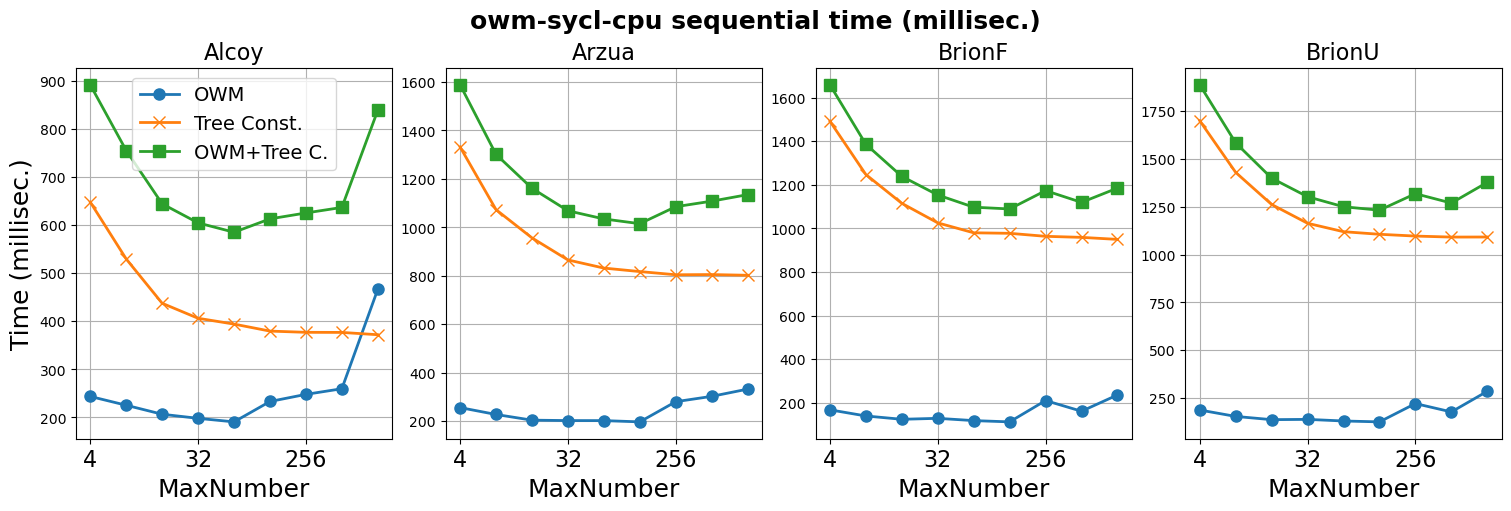

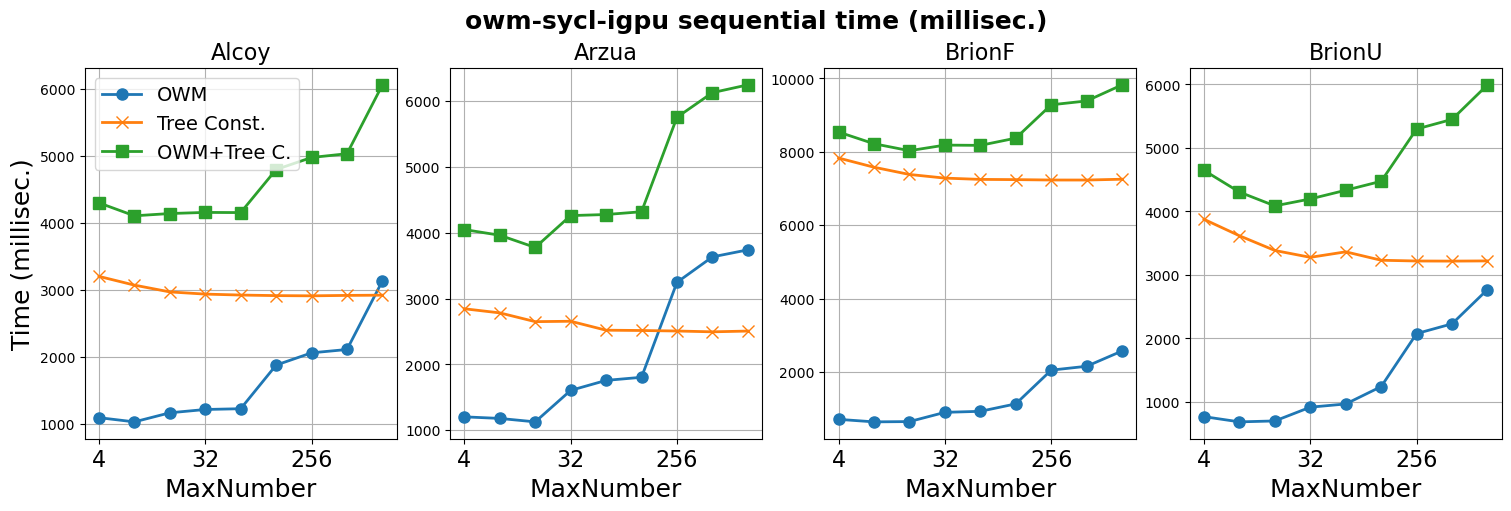

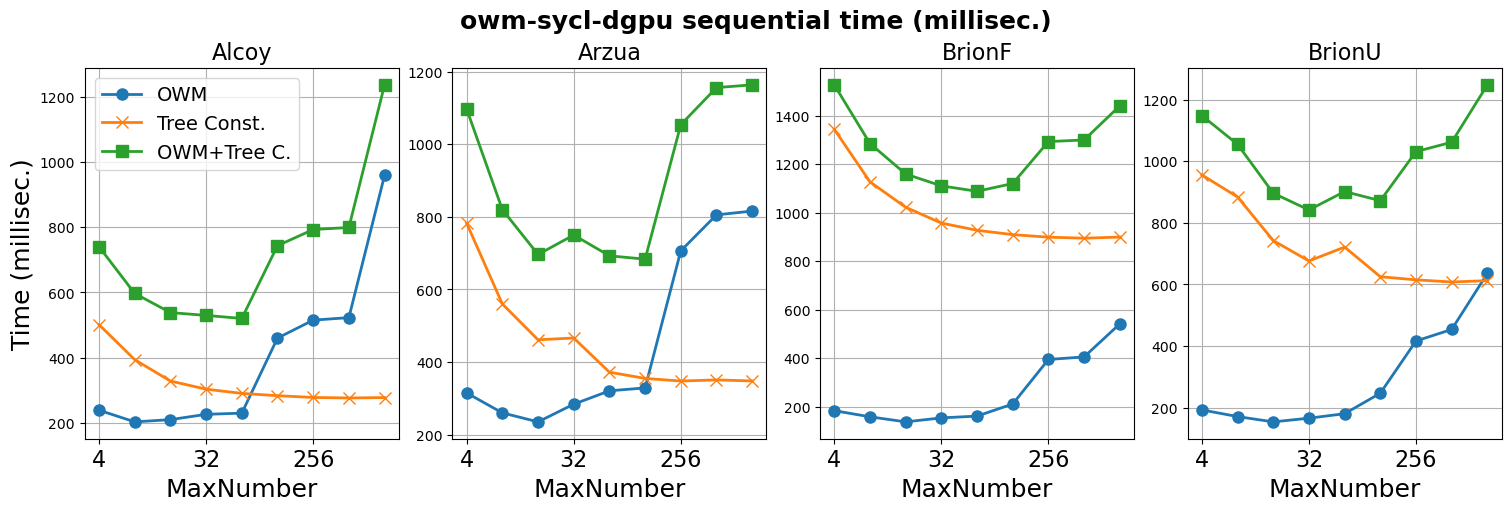

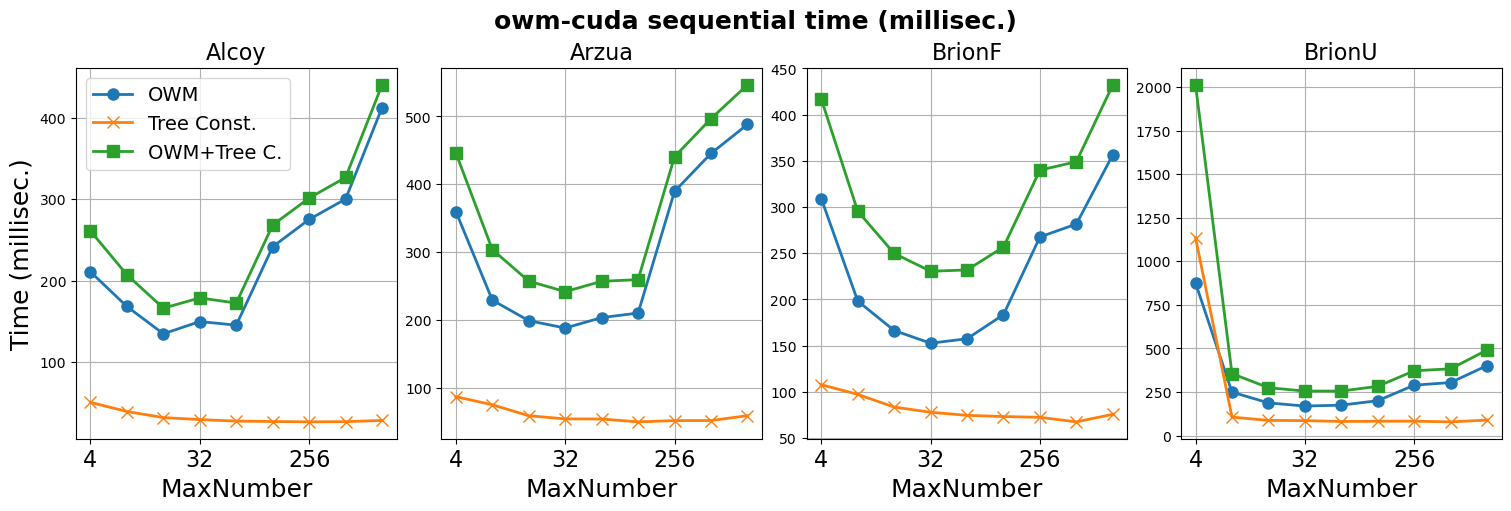

In [26]:
def plot_alltimes(results,version):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM','Tree Const.','OWM+Tree C.']
    x=list(results[version]['Alcoy'].keys())
    xticks=range(1,len(x)+1)
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][3] for i in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][0] for i in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(xticks), np.array([results[version][name][i][4] for i in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('MaxNumber', fontsize=xlabelfs)
        axs[i].set_xticks(ticks=xticks[::3], labels=x[::3],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle(version + ' sequential time (millisec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (millisec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()

plot_alltimes(res,"owm-sycl-cpu")
plot_alltimes(res,"owm-sycl-igpu")
plot_alltimes(res,"owm-sycl-dgpu")
plot_alltimes(res,"owm-cuda")

# Save results in All_Optimizations.csv

In [16]:
output="All_OptimizationsSYCL-CUDA.csv"

f = open(output, "a")

for ver in res:
    #print("Version {}".format(ver))
    for cloud in res[ver]:
        totaltimes=np.array([res[ver][cloud][i][4] for i in res[ver][cloud]])
        bestMNtotal=min(res[ver][cloud], key=lambda x: res[ver][cloud][x][4])
        bestTreeTime=res[ver][cloud][bestMNtotal][0]
        bestowmTime=res[ver][cloud][bestMNtotal][3]
        print("{};{};{:.5f};{:.5f};{};{}".format(ver,cloud,bestTreeTime/1000,bestowmTime/1000,0,bestMNtotal))
        f.write("{};{};{:.5f};{:.5f};{};{}\n".format(ver,cloud,bestTreeTime/1000,bestowmTime/1000,0,bestMNtotal))
f.close()

owm-sycl-cpu;Alcoy;0.39190;0.19109;0;64
owm-sycl-cpu;Arzua;0.81469;0.19765;0;128
owm-sycl-cpu;BrionF;0.97617;0.11153;0;128
owm-sycl-cpu;BrionU;1.10405;0.12631;0;128
owm-sycl-cpu-nomemo;Alcoy;0.39146;0.22724;0;64
owm-sycl-cpu-nomemo;Arzua;0.81833;0.26675;0;128
owm-sycl-cpu-nomemo;BrionF;0.96195;0.20382;0;512
owm-sycl-cpu-nomemo;BrionU;1.09199;0.23396;0;512
owm-sycl-dgpu;Alcoy;0.29006;0.22956;0;64
owm-sycl-dgpu;Arzua;0.35557;0.32924;0;128
owm-sycl-dgpu;BrionF;0.93017;0.16180;0;64
owm-sycl-dgpu;BrionU;0.67697;0.16601;0;32
owm-sycl-dgpu-nomemo;Alcoy;0.28955;0.27217;0;64
owm-sycl-dgpu-nomemo;Arzua;0.35560;0.47331;0;128
owm-sycl-dgpu-nomemo;BrionF;0.91357;0.43947;0;128
owm-sycl-dgpu-nomemo;BrionU;0.62585;0.49728;0;128
owm-cuda;Alcoy;0.02754;0.13281;0;16
owm-cuda;Arzua;0.05550;0.19173;0;32
owm-cuda;BrionF;0.07895;0.15254;0;32
owm-cuda;BrionU;0.08148;0.16935;0;32
owm-cuda-nomemo;Alcoy;0.02390;0.15596;0;64
owm-cuda-nomemo;Arzua;0.05319;0.26673;0;64
owm-cuda-nomemo;BrionF;0.06796;0.30039;0;256
o